### Import the libraries and packages

In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

### Loading the dataset

In [3]:
df = pd.read_csv('./flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [4]:
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


In [5]:
airports = pd.read_csv('./airports.csv')

In [6]:
df = df[df['MONTH'] == 1]

### Cleaning the dateset

In [7]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [8]:
# Converting 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

# Combining date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

# Combining two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [9]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)

df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [10]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [11]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [12]:
df.dropna(inplace = True)

### Comparing

In [13]:
airlines_names = pd.read_csv('./airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [14]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

### Statistical Description of Airlines

In [15]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


In [16]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312


In [17]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

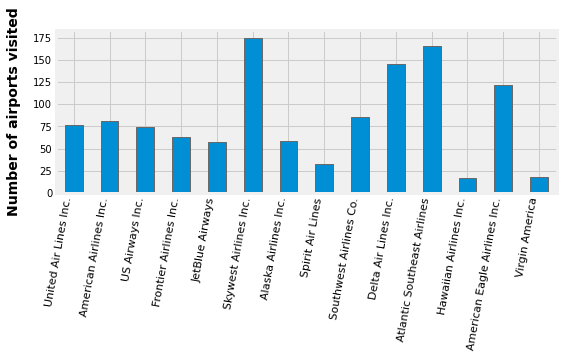

In [18]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [19]:
temp = pd.read_csv('./airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

### Airport Impact Delays

In [20]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

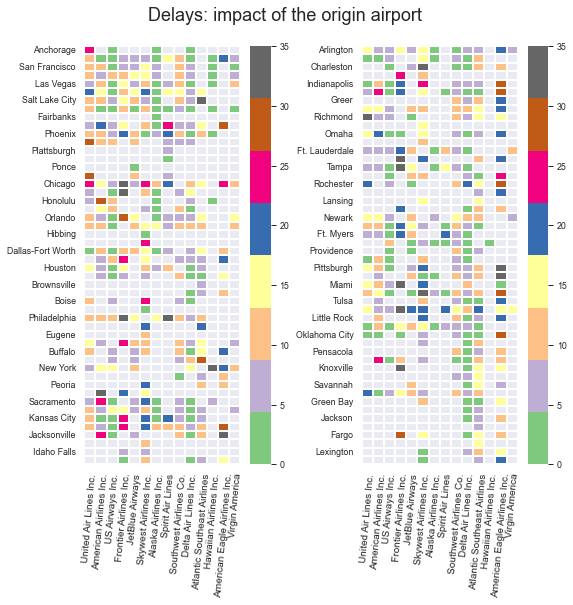

In [21]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

In [22]:
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]

# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]

# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

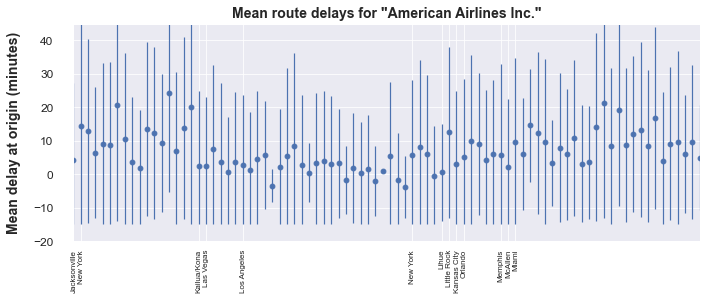

In [23]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

### Predicting delays 

In [24]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

In [25]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
JAC,-19.0,47.0,25.0,-3.640000
GUC,-24.0,199.0,22.0,13.227273
SDF,-8.0,55.0,19.0,8.421053
LIT,-5.0,74.0,9.0,12.555556
MTJ,-2.0,51.0,3.0,26.000000


In [26]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [27]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [28]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

modèle nº1 , min. pour n = 1, score = 21.9
modèle nº2 , min. pour n = 1, score = 191.2
modèle nº3 , min. pour n = 1, score = 50.1
modèle nº4 , min. pour n = 1, score = 28.0
modèle nº5 , min. pour n = 1, score = 194.4
modèle nº6 , min. pour n = 1, score = 141.9
modèle nº7 , min. pour n = 1, score = 156.1
modèle nº8 , min. pour n = 1, score = 129.9
modèle nº9 , min. pour n = 1, score = 17.0
modèle nº10, min. pour n = 1, score = 58.6
modèle nº11, min. pour n = 1, score = 60.9
modèle nº12, min. pour n = 2, score = 19.9
modèle nº13, min. pour n = 1, score = 37.1
modèle nº14, min. pour n = 1, score = 33.8
modèle nº15, min. pour n = 1, score = 62.5
modèle nº16, min. pour n = 1, score = 209.1
modèle nº17, min. pour n = 1, score = 21.9
modèle nº18, min. pour n = 1, score = 229.6
modèle nº19, min. pour n = 1, score = 53.4
modèle nº20, min. pour n = 1, score = 148.5
modèle nº21, min. pour n = 1, score = 142.1
modèle nº22, min. pour n = 1, score = 132.7
modèle nº23, min. pour n = 2, score = 66.1
m

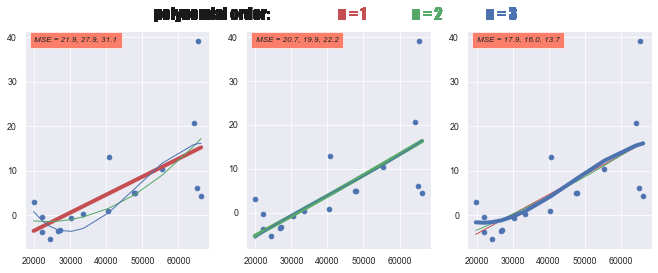

In [29]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break

In [30]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'neg_mean_squared_error'))

### K-fold

In [31]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 16 

n=1 -> MSE = 130.629
n=2 -> MSE = 151.79
n=3 -> MSE = 159.455
n=4 -> MSE = 162.631
n=5 -> MSE = 166.966
n=6 -> MSE = 173.08
n=7 -> MSE = 181.361


In [32]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

In [33]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

In [34]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

56.86284771892097

In [35]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

In [36]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

108.6713085157708

In [37]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 10.42 min'

In [38]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [39]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(1831, 3)

In [40]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [41]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1831, 82) (1831, 1)


#### Linaer Regression

In [42]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 53.74307365423859


In [43]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'5.30%'

In [44]:
import matplotlib.pyplot as plt

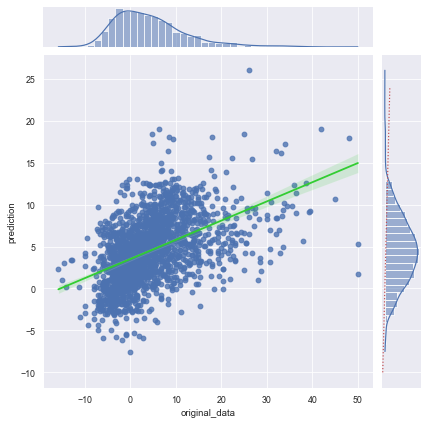

In [45]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.set()

In [46]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression()

In [47]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 49.502727299723986


In [48]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'4.81%'

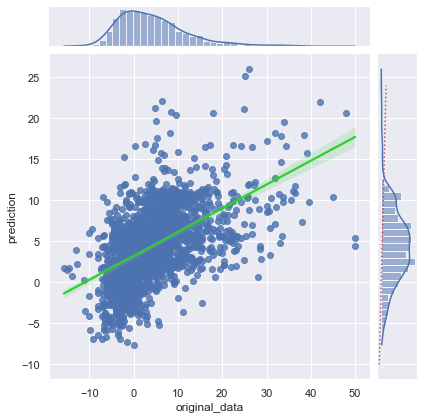

In [49]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.set()

### Setting free parameters

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [51]:
X_train.shape

(1281, 82)

In [52]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  47.56224785951498


In [53]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  2168.86484489059


In [54]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

1139879.2 -1042.5 25.2


In [55]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, normalize=True)

In [56]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  64.38257526079367


In [57]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 65.258
n=1 alpha=2 , MSE = 63.5
n=1 alpha=4 , MSE = 62.892
n=1 alpha=6 , MSE = 62.773
n=1 alpha=8 , MSE = 62.879
n=1 alpha=10 , MSE = 63.087
n=1 alpha=12 , MSE = 63.34
n=1 alpha=14 , MSE = 63.608
n=1 alpha=16 , MSE = 63.876
n=1 alpha=18 , MSE = 64.135
n=2 alpha=0 , MSE = 1.2069e+04
n=2 alpha=2 , MSE = 64.57
n=2 alpha=4 , MSE = 64.225
n=2 alpha=6 , MSE = 63.982
n=2 alpha=8 , MSE = 63.824
n=2 alpha=10 , MSE = 63.731
n=2 alpha=12 , MSE = 63.688
n=2 alpha=14 , MSE = 63.682
n=2 alpha=16 , MSE = 63.704
n=2 alpha=18 , MSE = 63.746


In [58]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

55.892912799059864


In [59]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

In [60]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [61]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

'MSE = 58.41'

In [62]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 7.64 min'

In [63]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))

ecarts > 15 minutes: 3.168%


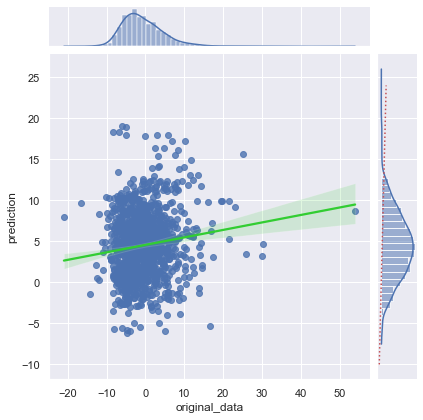

In [64]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.set()

In [65]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [66]:
df3 = create_df(df, carrier)    
df3[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,2.133333,2.800000
1,300,17700,LAX,5.500000,3.750000
2,600,28200,LAX,-6.000000,3.250000
3,1200,29040,LAX,-4.117647,2.823529
4,1200,29100,LAX,0.800000,3.600000


In [67]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [69]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 81.698
n=1 alpha=0.2 , MSE = 81.305
n=1 alpha=0.4 , MSE = 81.569
n=1 alpha=0.6 , MSE = 82.157
n=1 alpha=0.8 , MSE = 82.881
n=1 alpha=1.0 , MSE = 83.65
n=1 alpha=1.2 , MSE = 84.418
n=1 alpha=1.4 , MSE = 85.163
n=1 alpha=1.6 , MSE = 85.874
n=1 alpha=1.8 , MSE = 86.546
n=2 alpha=0.0 , MSE = 1856.5
n=2 alpha=0.2 , MSE = 82.809
n=2 alpha=0.4 , MSE = 82.467
n=2 alpha=0.6 , MSE = 82.325
n=2 alpha=0.8 , MSE = 82.279
n=2 alpha=1.0 , MSE = 82.298
n=2 alpha=1.2 , MSE = 82.364
n=2 alpha=1.4 , MSE = 82.467
n=2 alpha=1.6 , MSE = 82.598
n=2 alpha=1.8 , MSE = 82.752


In [70]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

84.791095471914


In [71]:
df3 = create_df(df_test, carrier)    
df3[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday
0,300,17640,LAX,-4.000,3.25
1,1200,29040,LAX,5.125,3.25
2,1800,20340,SFO,-6.750,3.25
3,2700,29340,LAS,-4.500,3.25
4,3900,31800,LAX,-4.875,3.25


In [72]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['heure_depart', 'heure_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [73]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 75.17


In [74]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 8.67 min'

In [75]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))

ecarts > 15 minutes: 4.588%


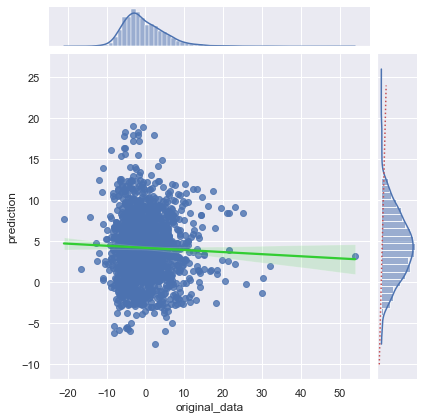

In [76]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()